<a href="https://colab.research.google.com/github/jegun19/predictive_maintenance/blob/main/train_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites
## Required steps:
<ol type="I">
<li>Install Kaggle API in Colab Environment</li>
<li>Upload API token from Kaggle in .json file </li>
<li>Download dataset from Kaggle</li>

---

## Connect to Kaggle
### First, install the Kaggle API in our environment and upload the API token file in form of .json file. Refer to this [link](https://www.kaggle.com/general/51898)

In [1]:
 !pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

## Prepare local environment
### Second, create directory in our environment to allow access to kaggle dataset. 

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

If everything goes well, we should be able to see list of datasets available

In [6]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18826  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          11424  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5875  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           4006  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

Then, we can use the following command to download the dataset that we are going to use

In [7]:
!kaggle datasets download -d arnabbiswas1/microsoft-azure-predictive-maintenance

 90% 28.0M/31.0M [00:00<00:00, 64.4MB/s]
100% 31.0M/31.0M [00:00<00:00, 103MB/s] 


In [8]:
!mkdir pdm_data

In [9]:
!unzip microsoft-azure-predictive-maintenance.zip -d pdm_data

Archive:  microsoft-azure-predictive-maintenance.zip
  inflating: pdm_data/PdM_errors.csv  
  inflating: pdm_data/PdM_failures.csv  
  inflating: pdm_data/PdM_machines.csv  
  inflating: pdm_data/PdM_maint.csv  
  inflating: pdm_data/PdM_telemetry.csv  




---


# Data Exploration


## Select one machine
In this step, we will take a look at the overall characteristic of the data, and then select one machine that we want to analyze and use for doing the predictive maintenance task.

In [10]:
# Load all csv datas using pandas
import os
import pandas as pd

WORKING_DIR = os.getcwd()

df_tele = pd.read_csv(WORKING_DIR + '/pdm_data/PdM_telemetry.csv')
df_fail = pd.read_csv(WORKING_DIR + '/pdm_data/PdM_failures.csv')
df_err = pd.read_csv(WORKING_DIR + '/pdm_data/PdM_errors.csv')
df_maint = pd.read_csv(WORKING_DIR + '/pdm_data/PdM_maint.csv')

In [11]:
# print the top 5 rows from the failure dataframe
df_fail.head(n=5)

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


For simplicity purpose, we will select a single machine that we are going to use for analysis. In this notebook, we will select machine number 11.

In [12]:
df_sel = df_tele.loc[df_tele['machineID'] == 11].reset_index(drop=True)
df_sel.head(n=5)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,11,164.039259,389.699577,113.619975,29.775109
1,2015-01-01 07:00:00,11,180.325510,409.788550,97.506203,40.512160
2,2015-01-01 08:00:00,11,146.917119,420.626012,97.087205,33.420937
3,2015-01-01 09:00:00,11,164.895416,426.409611,86.494413,40.263365
4,2015-01-01 10:00:00,11,174.330072,471.774231,109.277816,39.931749


Then, we will look into the error and failure record and then filter it only to show records belonging to machine number 11.

In [13]:
# Check failure record of machine 11
sel_fail = df_fail.loc[df_fail['machineID'] == 11]
pd.DataFrame(sel_fail)

,datetime,machineID,failure
58,2015-01-20 06:00:00,11,comp2
59,2015-02-19 06:00:00,11,comp3
60,2015-04-20 06:00:00,11,comp2
61,2015-04-20 06:00:00,11,comp3
62,2015-10-02 06:00:00,11,comp3
63,2015-12-16 06:00:00,11,comp3


In [14]:
# Check error record of machine 11
sel_err = df_err.loc[df_err['machineID'] == 11]
pd.DataFrame(sel_err).head()

,datetime,machineID,errorID
360,2015-01-19 06:00:00,11,error2
361,2015-01-19 06:00:00,11,error3
362,2015-02-15 01:00:00,11,error4
363,2015-02-18 06:00:00,11,error4
364,2015-02-26 23:00:00,11,error4


From the explanation regarding the difference between failure and error in Kaggle, it is described that error refers to non-breaking events while failure refers to events that cause the machine to fail. Then, we will see in chronological plot how does the two events relate to each other.

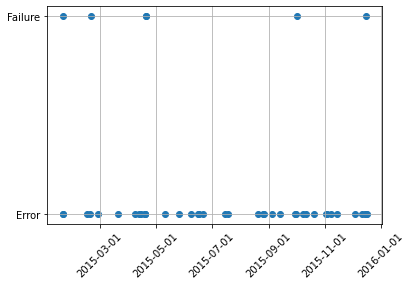

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()

# For a simpler plot, we will use two different values in the y-axis to differentiate between error and failure
y_category = list()

for iter in range(0, len(sel_fail)):
  y_category.append('Failure')

for iter in range(0, len(sel_err)):
  y_category.append('Error')

# Get timestamp from error and selected failure
df_timestamp = pd.concat([sel_fail['datetime'], sel_err['datetime']], ignore_index=True, axis=0)
df_plot = pd.DataFrame({"timestamp": df_timestamp, "category": y_category})
df_plot.loc[:, 'timestamp'] = pd.to_datetime(df_plot.loc[:, 'timestamp'])
df_plot.sort_values(by=['timestamp'], inplace=True, ignore_index=True)


# Plot the data with timestamp as x-axis
ax.scatter('timestamp', 'category', data = df_plot)
yearfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(yearfmt)
ax.tick_params(axis='x', rotation=45)
ax.grid()

From the plot above, we can see that failures are oftentimes preceded by error in the machine. However, not all error result in immediate failures. Some time may passes before the failure in machine occurs. Thus, in the next step, we are going to focus on the failure data and check which feature is affected by machine's failure.

## Feature check
Here, we will select the time window from the failure record, then plot each feature and check their response in the event of failures.

Text(0, 0.5, 'Rotation')

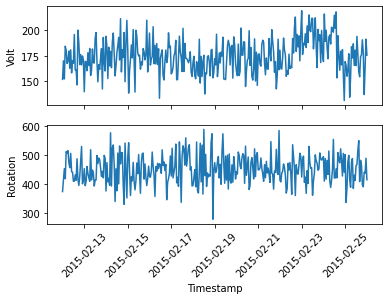

In [16]:
# Change datatype of the timestamp column from object to datetime
df_sel.loc[:, 'datetime'] = pd.to_datetime(df_sel.loc[:, 'datetime'])

# Select the date to check from failure records
st = df_sel.loc[df_sel['datetime'] == "2015-02-19"].index.values[0]

# Then, filter the telemetry data by the date and allow 7 days before and after
# the error occurs to observe any abnormalities.
select = df_sel.loc[st-7*24:st + 7*24,:]

# Plot volt and rotation feature
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot('datetime', 'volt', data=select)
ax[0].set_ylabel("Volt")

ax[1].plot('datetime', 'rotate', data=select)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel("Timestamp")
ax[1].set_ylabel("Rotation")

As we observe volt and rotation readings, no noticeable anomalies are shown around the period of 2015-02-19. Then, next we will check both pressure and vibration features by plotting them.

Text(0, 0.5, 'Vibration')

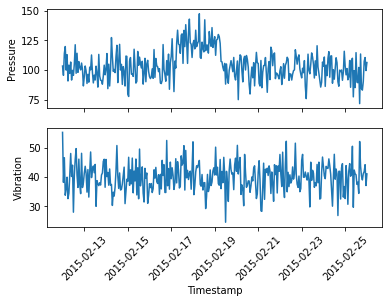

In [17]:
# Plot pressure and vibration feature
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot('datetime', 'pressure', data=select)
ax[0].set_ylabel("Pressure")

ax[1].plot('datetime', 'vibration', data=select)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel("Timestamp")
ax[1].set_ylabel("Vibration")

Between pressure and vibration, abnormality around the period of 2015-02-19 is more noticeable. Thus, in the next step, we will use <font color='red'>**pressure**</font> as feature and predictor. 

## Check autocorrelation and partial autocorrelation
In time-series data, it is beneficial to check the autocorrelation and partial autocorrelation function of the data that will influence our model selection and parameter selection.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


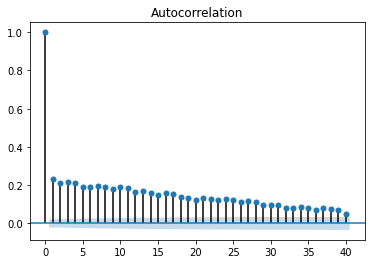

In [18]:
# Import plotting function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation plot
plot_acf(df_sel['pressure'], lags = 40)
plt.show()

From the autocorrelation plot, we can see that the data is positively correlated up to lags of 40, where the autocorrelation value itself is quite low, indicating that the data does not have a strong autocorrelation properties. 

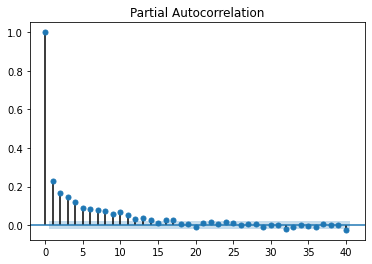

In [19]:
# Partial autocorrelation plot
plot_pacf(df_sel['pressure'], lags = 40)
plt.show()

From the partial autocorrelation plot, the correlation between values of two different points in time is also quite weak, decaying to zero starting in the 15th lags. This information will be used in determining the lag in the model.

# Model Selection

## Prepare data input and output
In this notebook, we will use LSTM model, one of the famous prediction model in time-series forecasting task. To use it, first we need to provide input and output data in the correct format.

For our experiment, we will use training data of 1 month containing 2015-02-19 period where failure happened to predict another failure which occurs at 2015-04-20 according to the failure record. The feature used will be the pressure reading and timestamp (one-hot encoded).

In [20]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Select the date to check from failure records
st_train = df_sel.loc[df_sel['datetime'] == "2015-02-19"].index.values[0]

# Then, filter the data to include approximately one month window
start_period = st_train - 14*24
end_period = st_train + 14*24

def create_feature(start, end):
  # create features from the selected machine
  pressure = df_sel.loc[start: end, 'pressure']
  timestamp = pd.to_datetime(df_sel.loc[start: end, 'datetime'])
  timestamp_hour = timestamp.map(lambda x: x.hour)
  timestamp_dow = timestamp.map(lambda x: x.dayofweek)

  # apply one-hot encode for timestamp data
  timestamp_hour_onehot = pd.get_dummies(timestamp_hour).to_numpy()

  # apply min-max scaler to numerical data
  scaler = MinMaxScaler()
  pressure = scaler.fit_transform(np.array(pressure).reshape(-1,1))

  # combine features into one
  feature = np.concatenate([pressure, timestamp_hour_onehot], axis=1)

  X = feature[:-1]
  y = np.array(feature[5:,0]).reshape(-1,1)

  return X, y, scaler

X, y, pres_scaler = create_feature(start_period, end_period)

Then, we need to shape the input further into a sequence (3-dimensional numpy array). We will use a function to return input and output sequence where each input sequence consists of 5-points observation. Simply put, observations of the <font color='red'>**past five hours**</font>  will be used to predict the sensor reading for the next <font color='red'>**one hour**</font> .

In [21]:
def shape_sequence(arr, step, start):
    out = list()
    for i in range(start, arr.shape[0]):
        low_lim = i
        up_lim = low_lim + step
        out.append(arr[low_lim: up_lim])

        if up_lim == arr.shape[0]:
          # print(i)
          break

    out_seq = np.array(out)
    return out_seq

# Shape the sequence according to the length specified
X_seq = shape_sequence(X, 5, 0)
y_seq = shape_sequence(y, 1, 0)

# Separate the input and output for train and validation
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

print("Training data shape = ", X_train.shape)
print("Validation data shape = ", X_val.shape)

Training data shape =  (534, 5, 25)
Validation data shape =  (134, 5, 25)


## Create prediction model

Create a simple 2-layer LSTM model with input shape matching the shape of the data sequence provided.

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.losses as loss


def create_model(X_train, y_train):
  shape = X_train.shape[1]
  feat_length = X_train.shape[2]

  model = Sequential()
  model.add(LSTM(shape, activation='tanh', input_shape=(shape, feat_length), return_sequences=True))
  model.add(LSTM(shape, activation='tanh', input_shape=(shape, feat_length), return_sequences=False))
  model.add(Dense(shape, activation='relu'))
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer=Adam(lr=0.035),
                loss=loss.mean_squared_error)
  model.fit(X_train, y_train, verbose=1, epochs=500)

  return model

model = create_model(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/500
17/17 [==============================] - 5s 8ms/step - loss: 0.0473
Epoch 2/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0227
Epoch 3/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0219
Epoch 4/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0218
Epoch 5/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0218
Epoch 6/500
17/17 [==============================] - 0s 9ms/step - loss: 0.0215
Epoch 7/500
17/17 [==============================] - 0s 10ms/step - loss: 0.0215
Epoch 8/500
17/17 [==============================] - 0s 9ms/step - loss: 0.0197
Epoch 9/500
17/17 [==============================] - 0s 10ms/step - loss: 0.0187
Epoch 10/500
17/17 [==============================] - 0s 10ms/step - loss: 0.0194
Epoch 11/500
17/17 [==============================] - 0s 9ms/step - loss: 0.0162
Epoch 12/500
17/17 [==============================] - 0s 10ms/step - loss: 0.0162
Epoch 13/500
17/17 [=============

## Check validation result
We will check the model's performance with validation data.

Validation error =  0.024012452


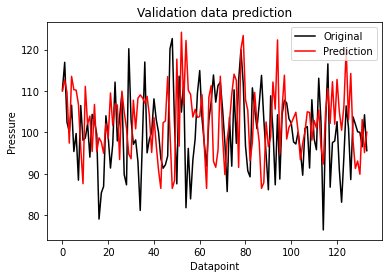

In [23]:
# Predict validation data using the trained model
y_pred = model.predict(X_val)
mse = MeanSquaredError()
val_err = mse(y_val.reshape(-1,1), y_pred)
print("Validation error = ", val_err.numpy())
# Return the value using inverse transform to allow better observation
plt.plot(pres_scaler.inverse_transform(y_val.reshape(-1,1)), 'k', label='Original')
plt.plot(pres_scaler.inverse_transform(y_pred.reshape(-1,1)), 'r', label='Prediction')
plt.ylabel("Pressure")
plt.xlabel("Datapoint")
plt.title("Validation data prediction")
plt.legend()
plt.show()

## Check test result

From the plot, we can see that some of the data points are inaccurate, which can be caused by the highly fluctuating nature of the hourly data points. Next, we will see whether the model can predict the sensor reading correctly in the event of anomalies. We are going to pick another date where failure occurred (2015-04-20).

Testing error =  0.046008497


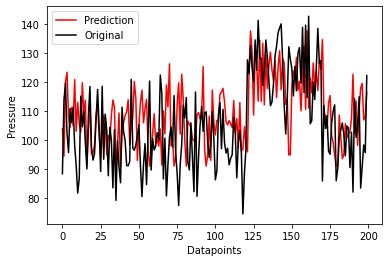

In [24]:
# Select the date where another failure occurred
st_test = df_sel.loc[df_sel['datetime'] == "2015-04-20"].index.values[0]

# Then, filter the data to include approximately two-weeks window
start_period_test = st_test - 7*24
end_period_test = st_test + 7*24
X_test, y_test, test_scaler = create_feature(start_period_test, end_period_test)

# Shape the sequence 
X_test_seq = shape_sequence(X_test, 5, 0)
y_test_seq = shape_sequence(y_test, 1, 0)

# Predict the testing data
y_pred_test = model.predict(X_test_seq)
test_err = mse(y_test_seq.reshape(-1,1), y_pred_test)
print("Testing error = ", test_err.numpy())

# Select first 200 datapoints to allow for better plotting
# Return the value using inverse transform to allow better observation
plt.plot(test_scaler.inverse_transform(y_pred_test[:200].reshape(-1, 1)), 'r', label='Prediction')
plt.plot(test_scaler.inverse_transform(y_test_seq[:200].reshape(-1, 1)), 'k', label='Original')
plt.ylabel("Pressure")
plt.xlabel("Datapoints")
plt.legend()
plt.show()

We observe that the model can predict the sensor reading even in the event of machine failure. The key here is to make sure that the training data that we use to train include past failure event as well.

# Further Steps
Now that we know how to construct a time-series forecasting model to predict anomalies, there are several possible steps on how to develop a complete predictive maintenance solution:
* Develop machine learning / deep learning model to predict the chance of machine breakdown by feeding it prediction results from our developed time-series forecasting model.
* Look into signal processing algorithm to smoothen the signal before feeding it to time-series forecasting model, which could improve model's performance.
* Use bigger subset of data in training process and check how does the model change, better or worse? 
* Do hyperparameter optimization to further optimize the performance of time-series forecasting model. 

# Conclusion
In this notebook, we have looked into an example predictive maintenance data from Kaggle, do some prior analysis on it, and construct a time-series forecasting model that will predict sensor reading values in the future. Hopefully, this notebook could provide some insights regarding how to implement time-series forecasting with deep learning in predictive maintenance.